#### Usaremos Vit-Large en vez de Vit-Base y se descongelan más capas que en las pruebas anteriores. Además se configura con 10 épocas

Resolving data files:   0%|          | 0/13128 [00:00<?, ?it/s]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=227x227 at 0x1779A4550>, 'label': 0}


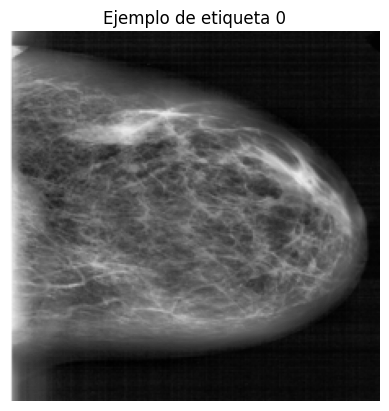

ClassLabel(names=['Benign', 'Malignant'], id=None)
{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=227x227 at 0x30806D250>, 'label': 0}


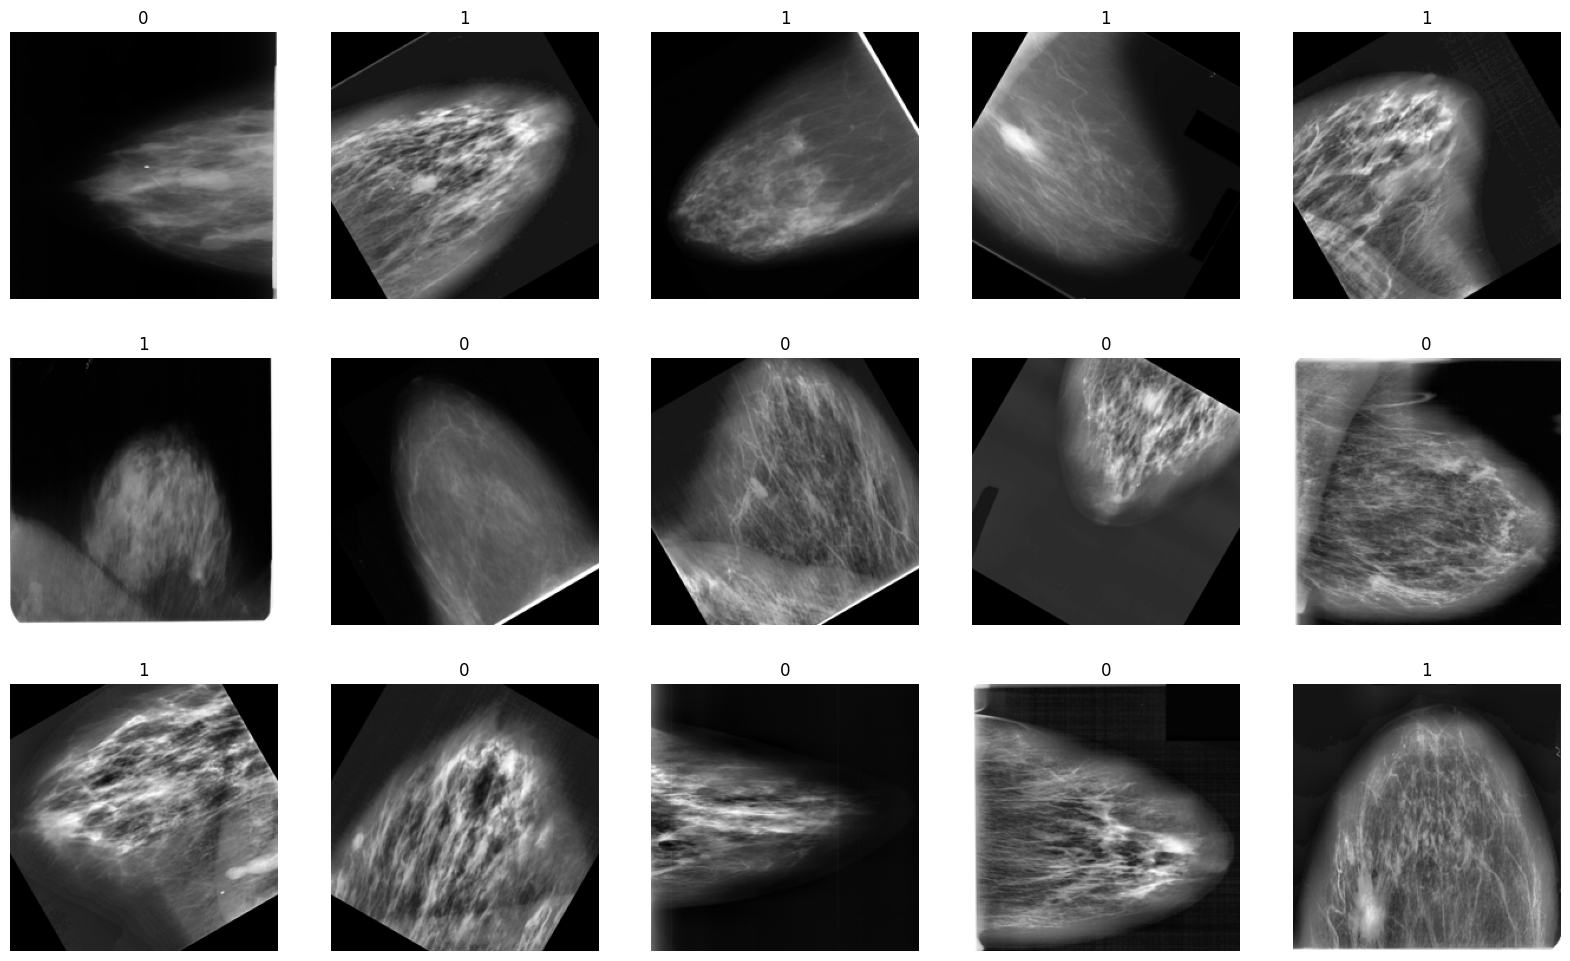

In [1]:
# =============================================================================
# Parte 1: Carga y Preprocesamiento de Datos
# =============================================================================

# Importación de bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from datasets import load_dataset, DatasetDict, ClassLabel
from transformers import AutoImageProcessor

import evaluate  # Biblioteca para métricas de evaluación

# -----------------------------------------------------------------------------
# Carga del conjunto de datos
# -----------------------------------------------------------------------------

# Se carga el conjunto de datos desde la ruta especificada
dataset = load_dataset('/Volumes/m2/Memoria/Code/PMM/BeningMalignant_Masses-Preprocessing/data/original/BeningMalignant_Masses/DDSM Dataset')

# Inspección del primer ejemplo del conjunto de entrenamiento
print(dataset['train'][0])

# -----------------------------------------------------------------------------
# Visualización de una imagen de ejemplo
# -----------------------------------------------------------------------------

# Obtener la imagen y mostrarla
im = dataset['train'][0]['image']
plt.imshow(im, cmap='gray')
plt.title('Ejemplo de etiqueta 0')
plt.axis('off')
plt.show()

# -----------------------------------------------------------------------------
# Mapeo de etiquetas numéricas a texto
# -----------------------------------------------------------------------------

# Definir el mapeo de etiquetas
label_map = {0: 'Benign', 1: 'Malignant'}

# Actualizar las características del conjunto de datos para incluir nombres de etiquetas
features = dataset['train'].features.copy()
features['label'] = ClassLabel(names=['Benign', 'Malignant'])

# Aplicar el mapeo al conjunto de datos
dataset = dataset.cast(features)

# Verificar las nuevas etiquetas
print(dataset['train'].features['label'])
print(dataset['train'][0])

# Crear diccionarios para mapeo entre etiquetas y IDs
labels = dataset['train'].unique('label')
label2id = {c: idx for idx, c in enumerate(labels)}
id2label = {idx: c for idx, c in enumerate(labels)}

# -----------------------------------------------------------------------------
# Visualización de muestras aleatorias
# -----------------------------------------------------------------------------

def show_samples(ds, rows, cols):
    """
    Muestra una cuadrícula de imágenes y etiquetas aleatorias del conjunto de datos.

    Args:
        ds (Dataset): Conjunto de datos de Hugging Face.
        rows (int): Número de filas en la cuadrícula.
        cols (int): Número de columnas en la cuadrícula.
    """
    samples = ds.shuffle().select(np.arange(rows * cols))
    fig = plt.figure(figsize=(cols * 4, rows * 4))
    for i in range(rows * cols):
        img = samples[i]['image']
        label = samples[i]['label']
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.show()

# Mostrar muestras del conjunto de entrenamiento
show_samples(dataset['train'], rows=3, cols=5)

# -----------------------------------------------------------------------------
# División del conjunto de datos en entrenamiento, validación y prueba
# -----------------------------------------------------------------------------

# Dividir el conjunto de entrenamiento en entrenamiento y prueba intermedia
split_dataset = dataset['train'].train_test_split(test_size=0.2)

# Dividir el conjunto de prueba intermedia en validación y prueba
eval_dataset = split_dataset['test'].train_test_split(test_size=0.5)

# Crear el conjunto de datos final con entrenamiento, validación y prueba
final_dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': eval_dataset['train'],
    'test': eval_dataset['test']
})

# -----------------------------------------------------------------------------
# Preprocesamiento de las imágenes
# -----------------------------------------------------------------------------

# Cargar el procesador de imágenes preentrenado
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224', use_fast=True)

def transforms(batch):
    """
    Aplica transformaciones a un batch de datos.

    Args:
        batch (dict): Batch de datos.

    Returns:
        dict: Batch transformado con 'pixel_values' y 'labels'.
    """
    # Convertir imágenes a RGB
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    # Procesar imágenes
    inputs = processor(batch['image'], return_tensors='pt')
    # Mapear etiquetas de texto a IDs numéricos
    inputs['labels'] = [label2id[y] for y in batch['label']]
    return inputs

# Aplicar las transformaciones al conjunto de datos
processed_dataset = final_dataset.with_transform(transforms)

# -----------------------------------------------------------------------------
# Definición de la función de colación de datos
# -----------------------------------------------------------------------------

def collate_fn(batch):
    """
    Función personalizada para colacionar los datos en batches.

    Args:
        batch (list): Lista de ejemplos.

    Returns:
        dict: Batch colacionado con 'pixel_values' y 'labels' como tensores.
    """
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

# -----------------------------------------------------------------------------
# Definición de la métrica de evaluación
# -----------------------------------------------------------------------------

# Cargar la métrica de precisión
accuracy = evaluate.load('accuracy')

def compute_metrics(eval_preds):
    """
    Calcula las métricas de evaluación.

    Args:
        eval_preds (tuple): Tupla que contiene logits y etiquetas verdaderas.

    Returns:
        dict: Diccionario con la precisión calculada.
    """
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score


In [2]:
# =============================================================================
# Parte 2: Configuración y Entrenamiento del Modelo con Correcciones
# =============================================================================

from transformers import ViTForImageClassification, Trainer, TrainingArguments
from transformers import TrainerCallback
from torch.utils.tensorboard import SummaryWriter
import torch

# -----------------------------------------------------------------------------
# Carga del modelo preentrenado
# -----------------------------------------------------------------------------

# Actualizar el modelo ViT preentrenado a la versión "large"
model = ViTForImageClassification.from_pretrained(
    'google/vit-large-patch16-224',
    num_labels=len(labels),
    ignore_mismatched_sizes=True
)

# -----------------------------------------------------------------------------
# Congelar todas las capas excepto el clasificador
# -----------------------------------------------------------------------------

for name, p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

# Mostrar el número total de parámetros y los entrenables
num_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total de parámetros: {num_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")

# -----------------------------------------------------------------------------
# Descongelar las últimas 5 capas del encoder para fine-tuning
# -----------------------------------------------------------------------------

# Obtener el número total de capas en el encoder
num_total_layers = len(list(model.vit.encoder.layer))  # Debería ser 24 para ViT-Large

# Definir el número de capas a descongelar
num_layers_to_unfreeze = 5

# Calcular el índice a partir del cual descongelar
unfreeze_from = num_total_layers - num_layers_to_unfreeze

# Iterar sobre todas las capas del encoder
for idx, layer in enumerate(model.vit.encoder.layer):
    if idx >= unfreeze_from:
        # Descongelar esta capa
        for param in layer.parameters():
            param.requires_grad = True
    else:
        # Congelar esta capa
        for param in layer.parameters():
            param.requires_grad = False

# Asegurarse de que el clasificador está descongelado
for param in model.classifier.parameters():
    param.requires_grad = True

# Mostrar el número total de parámetros y los entrenables después de descongelar
num_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Después de descongelar las últimas {num_layers_to_unfreeze} capas:")
print(f"Total de parámetros: {num_params:,}")
print(f"Parámetros entrenables: {trainable_params:,}")

# -----------------------------------------------------------------------------
# Detectar el dispositivo disponible
# -----------------------------------------------------------------------------

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Dispositivo utilizado para el entrenamiento: {device}")

# -----------------------------------------------------------------------------
# Configuración de los argumentos de entrenamiento con TensorBoard
# -----------------------------------------------------------------------------

training_args = TrainingArguments(
    output_dir="./VT_P5",
    per_device_train_batch_size=8,  # Reducido para acomodar el mayor uso de memoria
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=10,
    learning_rate=3e-5,  # Posiblemente reducir la tasa de aprendizaje
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to='tensorboard',  # Reportar a TensorBoard
    logging_dir='./VT_P5/runs',  # Directorio de logs para TensorBoard
    load_best_model_at_end=True,
    fp16=True if device == 'cuda' else False,  # Habilitar fp16 solo si CUDA está disponible
    # Eliminado 'torch_dtype' ya que no es un argumento válido
)

# Verificar la configuración de TrainingArguments
print(f"fp16 habilitado: {training_args.fp16}")

# -----------------------------------------------------------------------------
# Definición del Callback Personalizado para TensorBoard 
# -----------------------------------------------------------------------------

class CustomTensorBoardCallback(TrainerCallback):
    def __init__(self):
        super().__init__()
        self.writer = None

    def on_train_begin(self, args, state, control, **kwargs):
        if self.writer is None:
            # Inicializar el SummaryWriter de TensorBoard
            self.writer = SummaryWriter(log_dir=args.logging_dir)
            print(f"TensorBoard logs guardados en {args.logging_dir}")

    def on_log(self, args, state, control, logs=None, **kwargs):
        """
        Este método se llama cada vez que el trainer registra logs.
        """
        if self.writer and logs is not None:
            for k, v in logs.items():
                if isinstance(v, (int, float)):
                    self.writer.add_scalar(k, v, state.global_step)

    def on_epoch_end(self, args, state, control, **kwargs):
        """
        Registrar imágenes y predicciones al final de cada época.
        """
        # Asegurarse de que state.epoch no es None y convertirlo a entero
        if state.epoch is not None:
            epoch_seed = int(state.epoch)
        else:
            epoch_seed = 0  # Valor por defecto si state.epoch es None

        # Seleccionar muestras aleatorias del conjunto de validación
        samples = final_dataset['validation'].shuffle(seed=epoch_seed).select(range(4))
        processed_samples = samples.with_transform(transforms)
        predictions = trainer.predict(processed_samples).predictions.argmax(axis=1)

        for idx in range(len(samples)):
            img = samples[idx]['image']
            label_real = samples[idx]['label']
            label_pred = id2label[predictions[idx]]
            label = f"Real: {label_real}, Predicción: {label_pred}"
            img = img.convert('RGB')
            img_tensor = processor(images=img, return_tensors="pt")['pixel_values'][0].to(device)
            # Reescalar la imagen para visualización
            img_np = img_tensor.cpu().permute(1, 2, 0).numpy()
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

            # Añadir imagen al TensorBoard
            self.writer.add_image(f'Epoch_{epoch_seed}/Image_{idx}', img_np, dataformats='HWC')
            # Añadir texto con la etiqueta real y predicha
            self.writer.add_text(
                f'Epoch_{epoch_seed}/Prediction_{idx}',
                label,
                state.global_step
            )

    def on_train_end(self, args, state, control, **kwargs):
        if self.writer:
            self.writer.close()
            self.writer = None

# -----------------------------------------------------------------------------
# Inicialización del entrenador con el Callback de TensorBoard
# -----------------------------------------------------------------------------

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,         # Asegúrate de definir 'collate_fn'
    compute_metrics=compute_metrics,  # Asegúrate de definir 'compute_metrics'
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=processor,              # Asegúrate de definir 'processor'
    callbacks=[CustomTensorBoardCallback()],  # Añadir el callback personalizado
)

# -----------------------------------------------------------------------------
# Verificación de la disponibilidad de MPS (para dispositivos Apple)
# -----------------------------------------------------------------------------

# Ya hemos detectado el dispositivo anteriormente
if device == 'mps':
    print("Usando dispositivo MPS para el entrenamiento.")
elif device == 'cuda':
    print("Usando dispositivo CUDA para el entrenamiento.")
else:
    print("Usando CPU para el entrenamiento.")

# -----------------------------------------------------------------------------
# Entrenamiento del modelo
# -----------------------------------------------------------------------------

trainer.train()

# Guardar el modelo entrenado
trainer.save_model()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total de parámetros: 303,303,682
Parámetros entrenables: 2,050
Después de descongelar las últimas 5 capas:
Total de parámetros: 303,303,682
Parámetros entrenables: 62,983,170
Dispositivo utilizado para el entrenamiento: mps
fp16 habilitado: False


/Volumes/m2/Memoria/Code/PMM/venv2/lib/python3.11/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Usando dispositivo MPS para el entrenamiento.
TensorBoard logs guardados en ./VT_P5/runs


{'eval_loss': 6.303532427409664e-05, 'eval_accuracy': 1.0, 'eval_runtime': 140.909, 'eval_samples_per_second': 9.318, 'eval_steps_per_second': 1.171, 'epoch': 10.0}


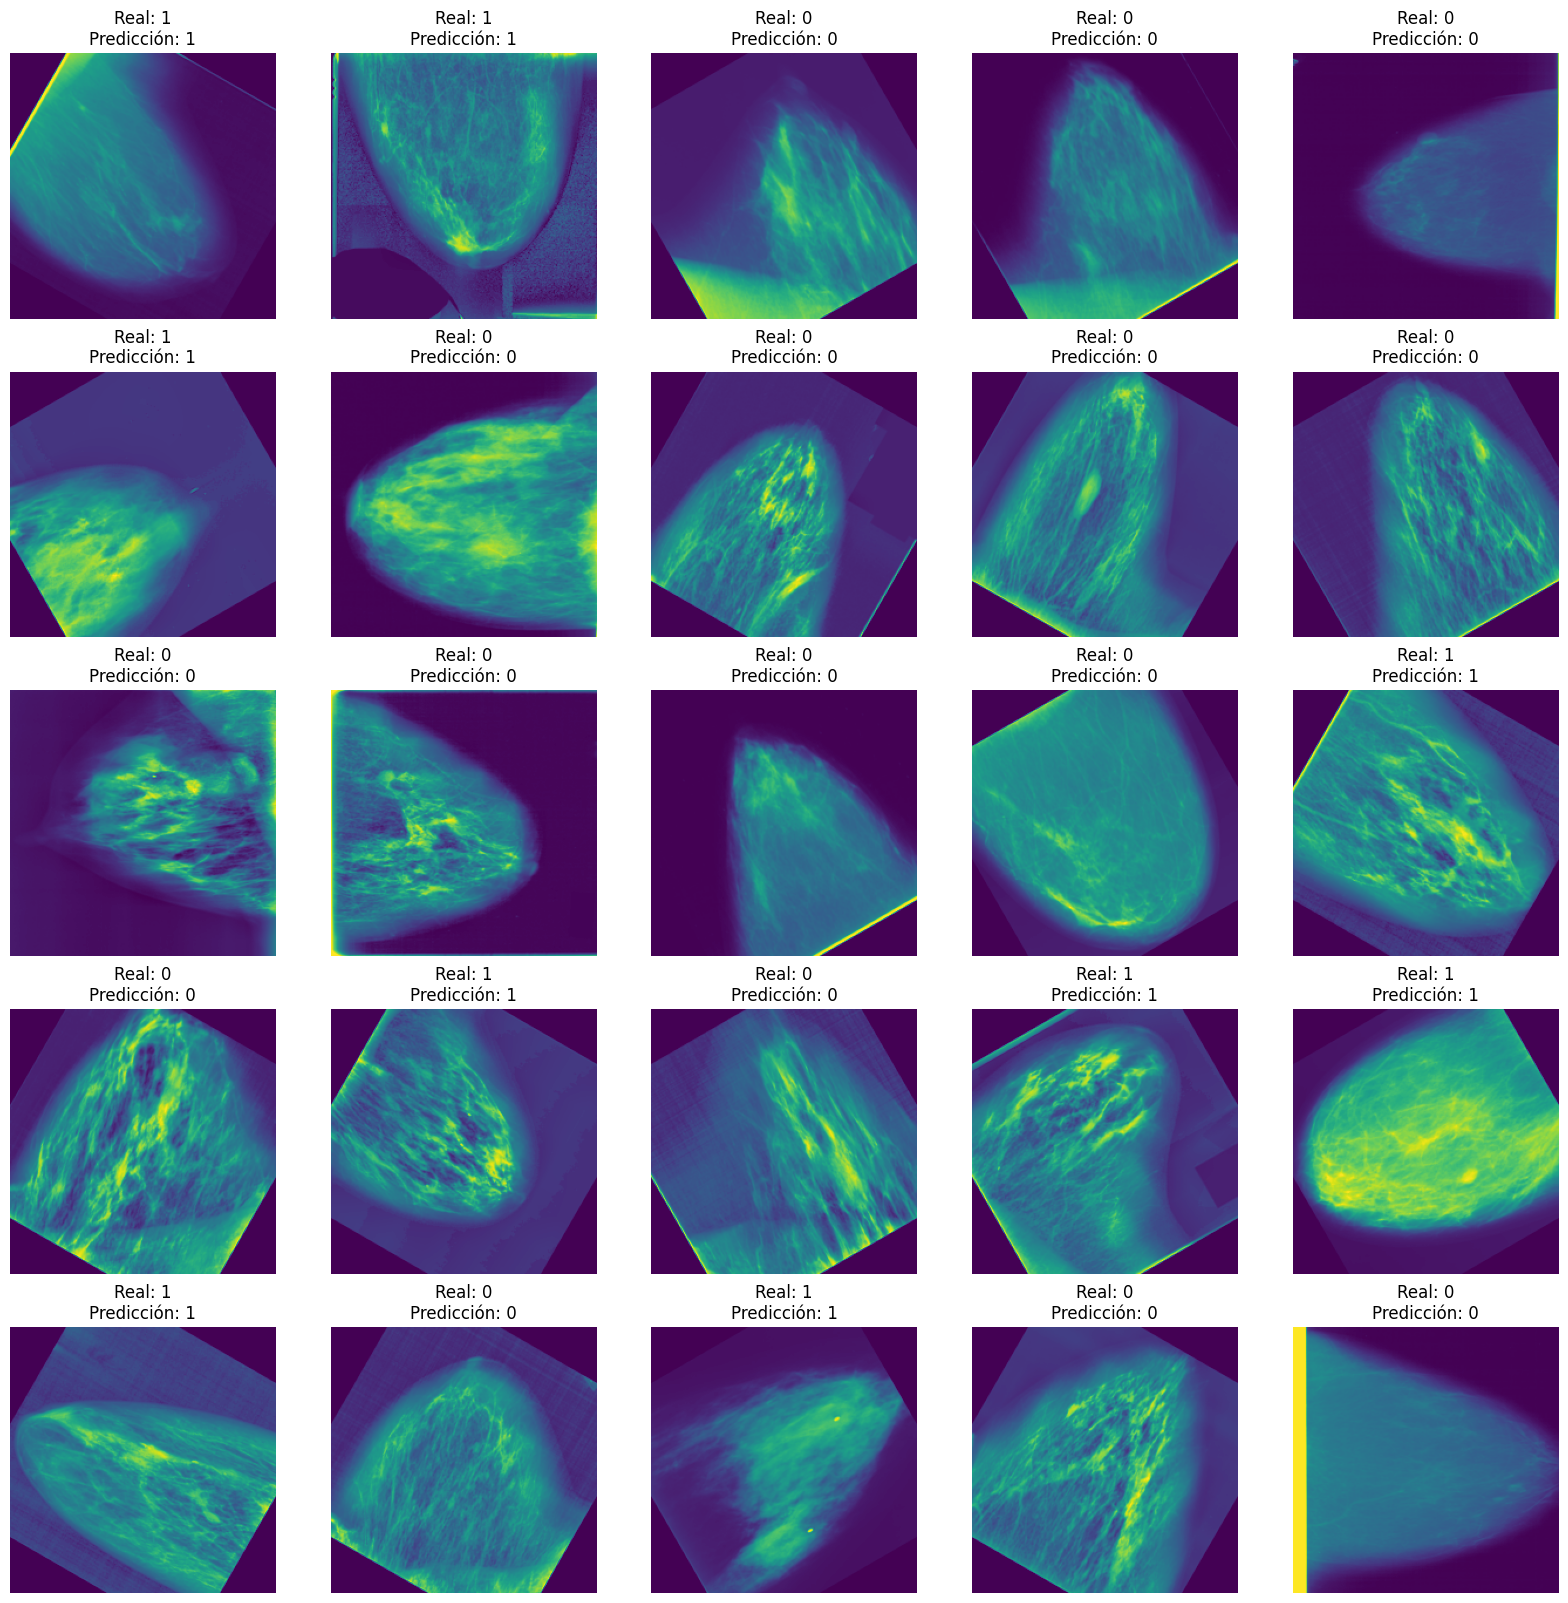

In [3]:
# =============================================================================
# Parte 3: Evaluación y Visualización de Resultados
# =============================================================================

# -----------------------------------------------------------------------------
# Evaluación del modelo en el conjunto de prueba
# -----------------------------------------------------------------------------

evaluation_results = trainer.evaluate(processed_dataset['test'])
print(evaluation_results)

# -----------------------------------------------------------------------------
# Función para mostrar predicciones
# -----------------------------------------------------------------------------

def show_predictions(rows, cols):
    """
    Muestra una cuadrícula de imágenes con sus etiquetas reales y predicciones.

    Args:
        rows (int): Número de filas en la cuadrícula.
        cols (int): Número de columnas en la cuadrícula.
    """
    samples = final_dataset['test'].shuffle().select(np.arange(rows * cols))
    processed_samples = samples.with_transform(transforms)
    predictions = trainer.predict(processed_samples).predictions.argmax(axis=1)
    fig = plt.figure(figsize=(cols * 4, rows * 4))
    for i in range(rows * cols):
        img = samples[i]['image']
        prediction = predictions[i]
        label_real = samples[i]['label']
        label_pred = id2label[prediction]
        label = f"Real: {label_real}\nPredicción: {label_pred}"
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

# Mostrar predicciones en el conjunto de prueba
show_predictions(rows=5, cols=5)


#### Vemos qué capas están congeladas y cuales no.

In [23]:
for name, param in model.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"{name}: {status}")


vit.embeddings.cls_token: Frozen
vit.embeddings.position_embeddings: Frozen
vit.embeddings.patch_embeddings.projection.weight: Frozen
vit.embeddings.patch_embeddings.projection.bias: Frozen
vit.encoder.layer.0.attention.attention.query.weight: Frozen
vit.encoder.layer.0.attention.attention.query.bias: Frozen
vit.encoder.layer.0.attention.attention.key.weight: Frozen
vit.encoder.layer.0.attention.attention.key.bias: Frozen
vit.encoder.layer.0.attention.attention.value.weight: Frozen
vit.encoder.layer.0.attention.attention.value.bias: Frozen
vit.encoder.layer.0.attention.output.dense.weight: Frozen
vit.encoder.layer.0.attention.output.dense.bias: Frozen
vit.encoder.layer.0.intermediate.dense.weight: Frozen
vit.encoder.layer.0.intermediate.dense.bias: Frozen
vit.encoder.layer.0.output.dense.weight: Frozen
vit.encoder.layer.0.output.dense.bias: Frozen
vit.encoder.layer.0.layernorm_before.weight: Frozen
vit.encoder.layer.0.layernorm_before.bias: Frozen
vit.encoder.layer.0.layernorm_after.we

#### Notamos que están descongeladas las últimas 5 capas del encoder del modelo ViT-Large (capas 19 a 23) junto con el clasificador final. Esto permite que estas capas se ajusten durante el entrenamiento, mientras que el resto del encoder permanece congelado, conservando los pesos preentrenados y reduciendo el riesgo de sobreajuste.



### Verificamos si hay solapamiento entre los datos de entrenamiento y validación.

In [9]:
from datasets import concatenate_datasets

# Combina todos los splits existentes si hay más
combined_dataset = concatenate_datasets([dataset[split] for split in dataset.keys()])

# Asigna un 'id' único a cada muestra en el dataset combinado
combined_dataset = combined_dataset.map(lambda x, idx: {'id': idx}, with_indices=True)

# Ahora, realiza la división en train, validation y test desde el dataset combinado
split_dataset = combined_dataset.train_test_split(test_size=0.2, seed=42)

# Divide el 'test' intermedio en 'validation' y 'test' finales
eval_dataset = split_dataset['test'].train_test_split(test_size=0.5, seed=42)

# Crea el DatasetDict final con splits sin solapamientos
final_dataset = DatasetDict({
    'train': split_dataset['train'],
    'validation': eval_dataset['train'],
    'test': eval_dataset['test']
})

# Verificar que no haya solapamientos usando 'id's únicos
train_ids = set(final_dataset['train']['id'])
val_ids = set(final_dataset['validation']['id'])
test_ids = set(final_dataset['test']['id'])

assert train_ids.isdisjoint(val_ids), "Train y Validation tienen datos en común."
assert train_ids.isdisjoint(test_ids), "Train y Test tienen datos en común."
assert val_ids.isdisjoint(test_ids), "Validation y Test tienen datos en común."

print("No hay solapamiento entre los conjuntos de datos después de asignar 'id's únicos globalmente.")


Map:   0%|          | 0/13128 [00:00<?, ? examples/s]

No hay solapamiento entre los conjuntos de datos después de asignar 'id's únicos globalmente.


In [10]:
import hashlib
from PIL import Image

def hash_image(image):
    hasher = hashlib.md5()
    if image.mode != 'RGB':
        image = image.convert('RGB')
    hasher.update(image.tobytes())
    return hasher.hexdigest()

# Generar hashes para cada split
train_hashes = set(hash_image(img) for img in final_dataset['train']['image'])
val_hashes = set(hash_image(img) for img in final_dataset['validation']['image'])
test_hashes = set(hash_image(img) for img in final_dataset['test']['image'])

# Verificar que los hashes no se solapen
assert train_hashes.isdisjoint(val_hashes), "Train y Validation tienen imágenes en común."
assert train_hashes.isdisjoint(test_hashes), "Train y Test tienen imágenes en común."
assert val_hashes.isdisjoint(test_hashes), "Validation y Test tienen imágenes en común."

print("No hay solapamiento de imágenes entre los conjuntos de datos basados en hashes.")


No hay solapamiento de imágenes entre los conjuntos de datos basados en hashes.


### Generamos un reporte de la clasificación

id2label: {0: 'Benign Masses', 1: 'Malignant Masses'}
label2id: {'Benign Masses': 0, 'Malignant Masses': 1}
Columnas en 'final_dataset['test']': ['image', 'label', 'id']
Columnas en 'processed_dataset['test']': ['image', 'label', 'id']
{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=227x227 at 0x353AC3D10>, 'label': 1, 'id': 12610}


Tipo de labels_true: <class 'list'>
Tipo de predictions: <class 'list'>
Longitud de labels_true: 1313
Longitud de predictions: 1313
Primeras etiquetas verdaderas: [1, 1, 0, 1, 0]
Primeras predicciones: [1, 1, 0, 1, 0]
Reporte de Clasificación:
                  precision    recall  f1-score   support

   Benign Masses       1.00      1.00      1.00       592
Malignant Masses       1.00      1.00      1.00       721

        accuracy                           1.00      1313
       macro avg       1.00      1.00      1.00      1313
    weighted avg       1.00      1.00      1.00      1313



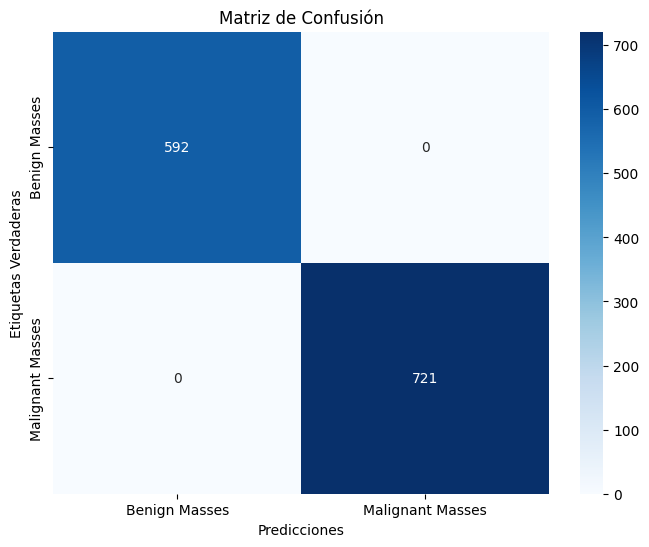

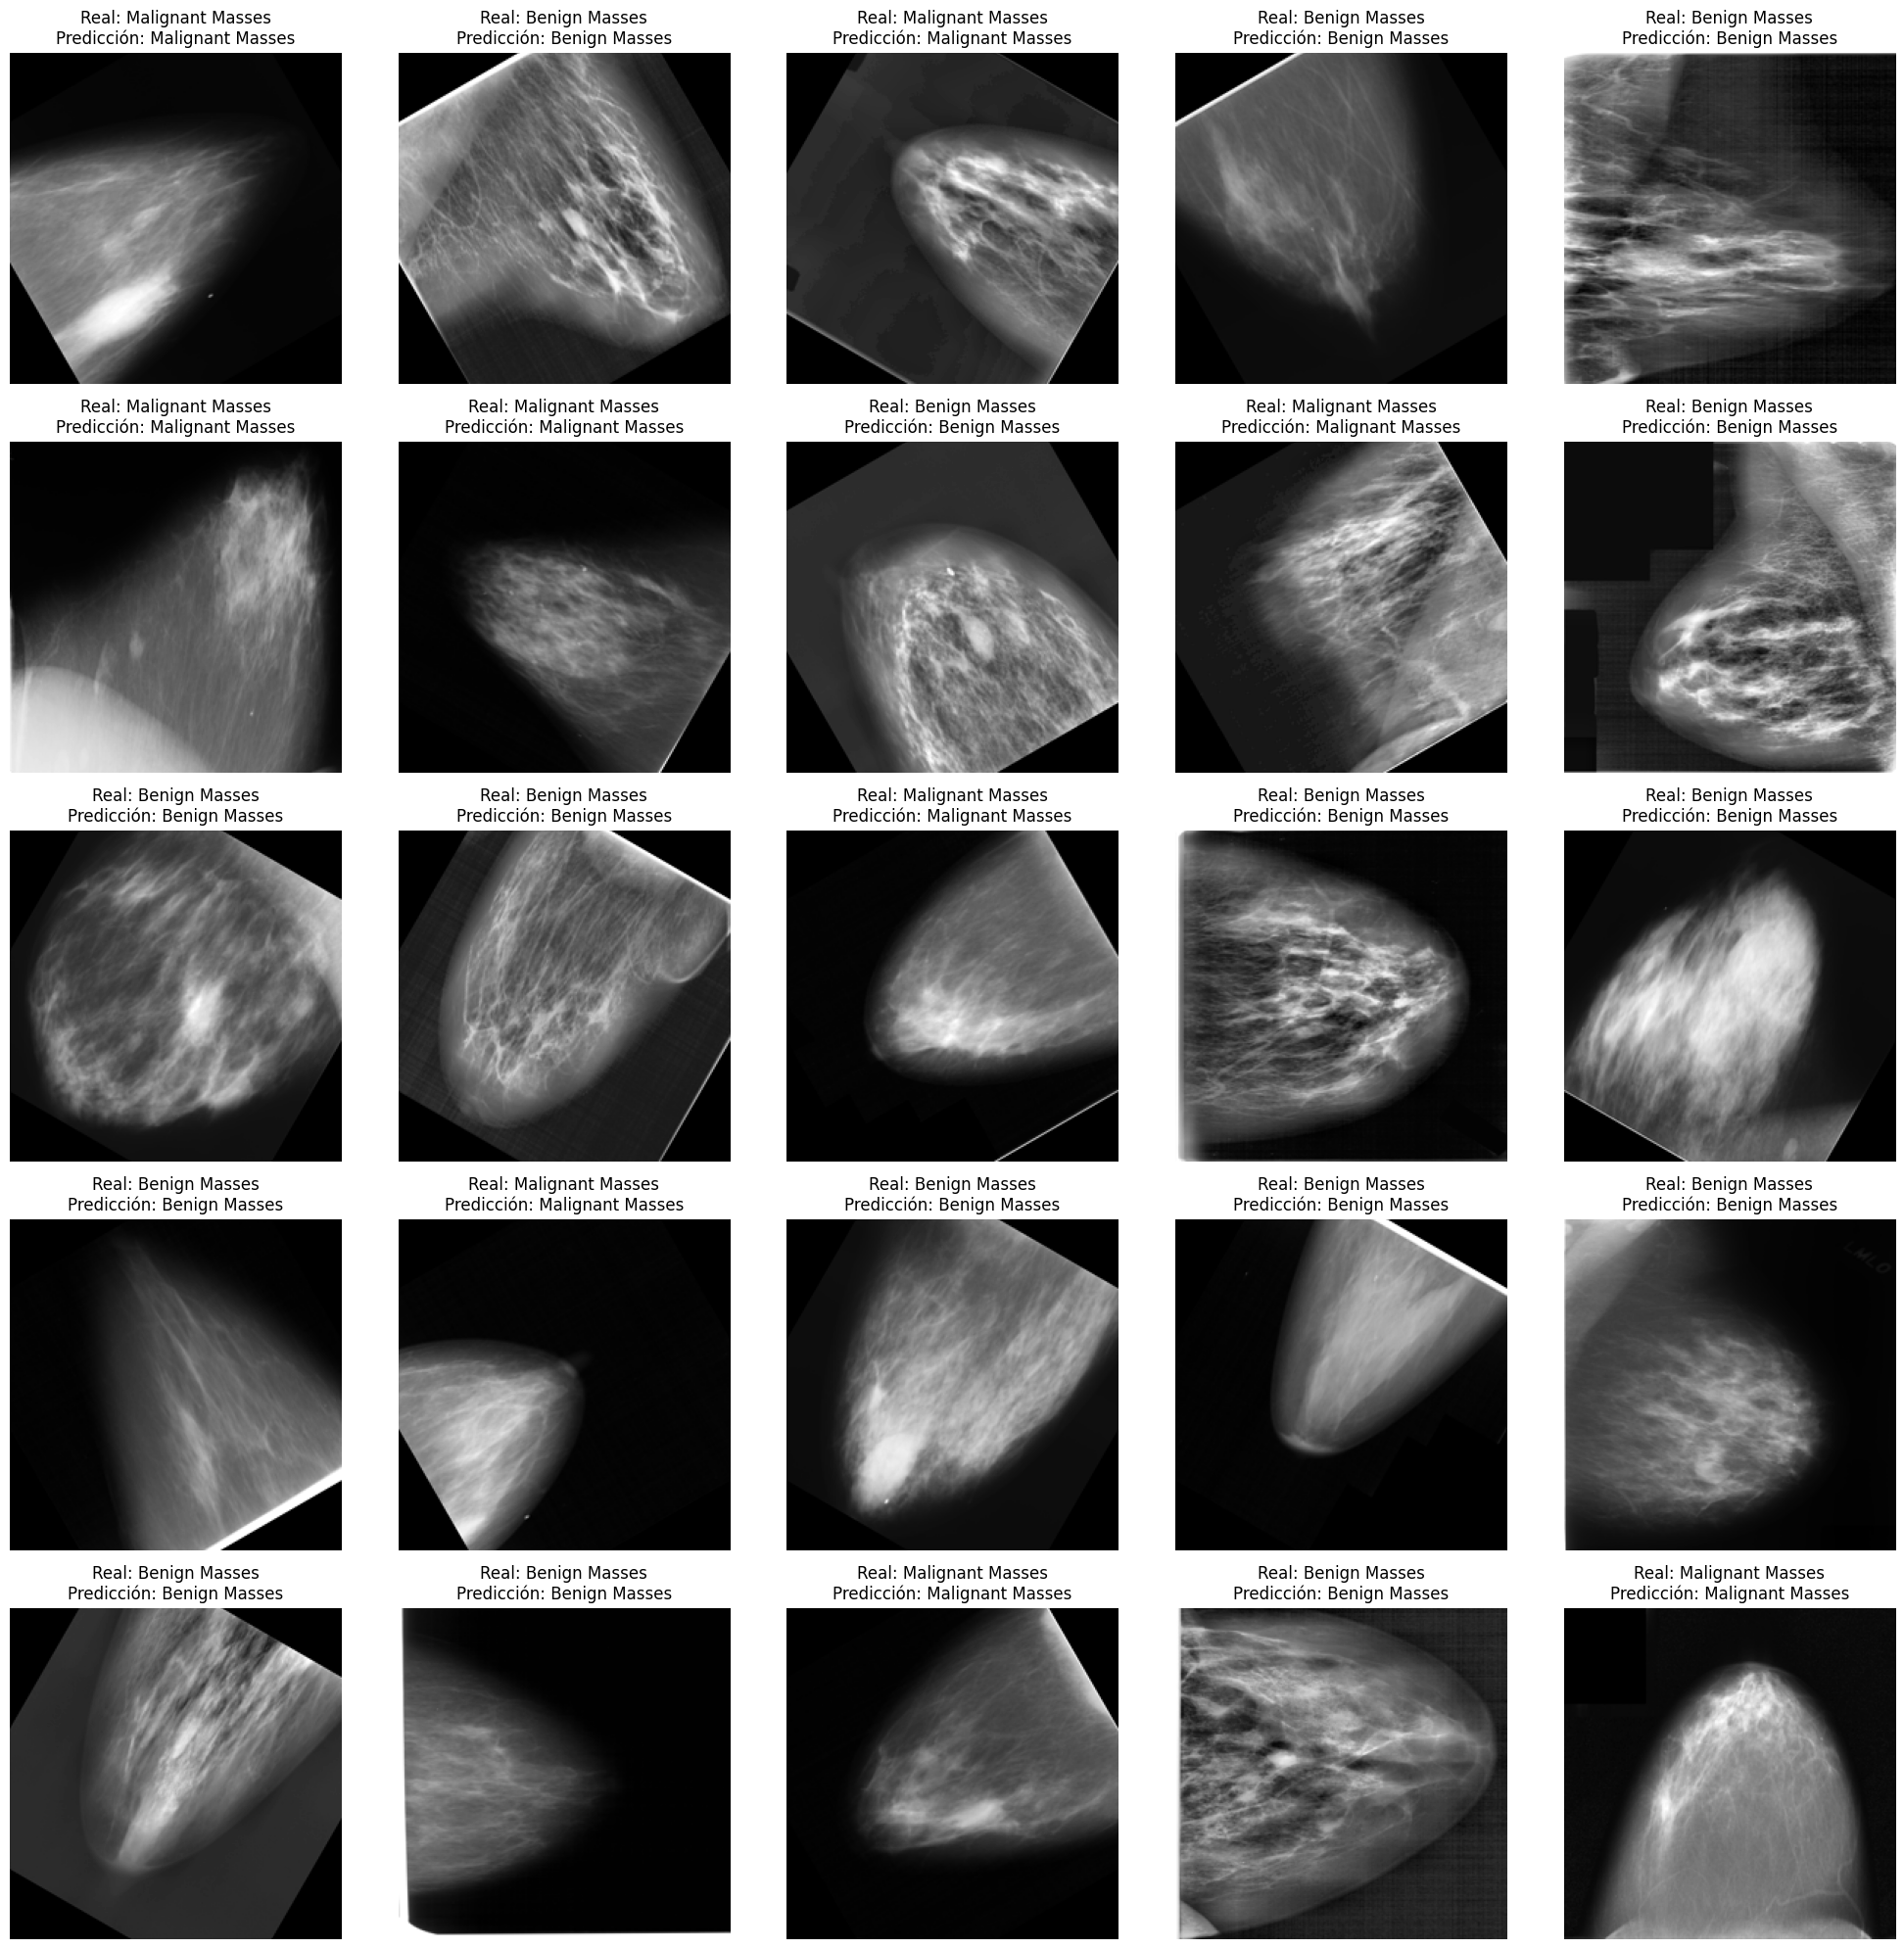

Imagen corrupta en train, índice 0: verify must be called directly after open
Imagen corrupta en train, índice 1: verify must be called directly after open
Imagen corrupta en train, índice 2: verify must be called directly after open
Imagen corrupta en train, índice 3: verify must be called directly after open
Imagen corrupta en train, índice 4: verify must be called directly after open
Imagen corrupta en train, índice 5: verify must be called directly after open
Imagen corrupta en train, índice 6: verify must be called directly after open
Imagen corrupta en train, índice 7: verify must be called directly after open
Imagen corrupta en train, índice 8: verify must be called directly after open
Imagen corrupta en train, índice 9: verify must be called directly after open
Imagen corrupta en train, índice 10: verify must be called directly after open
Imagen corrupta en train, índice 11: verify must be called directly after open
Imagen corrupta en train, índice 12: verify must be called dir

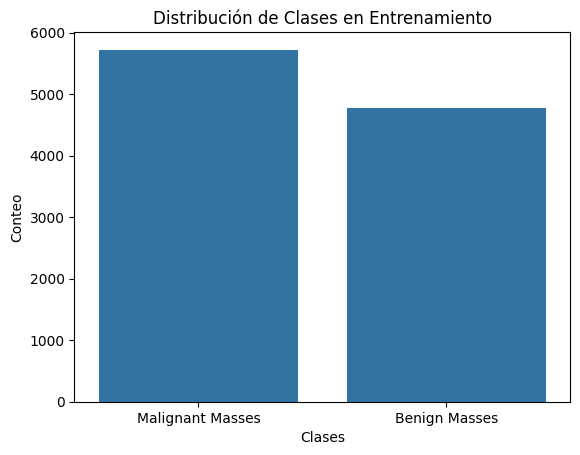

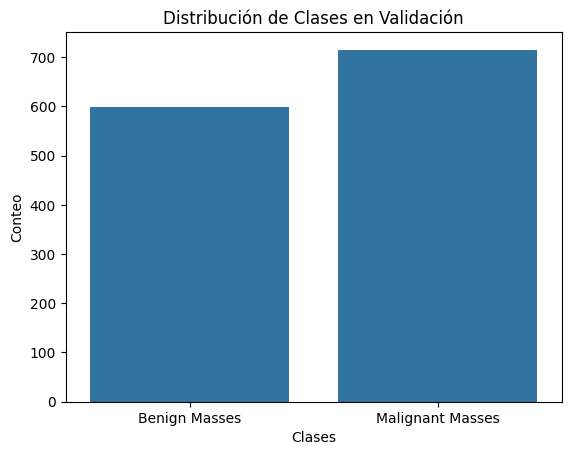

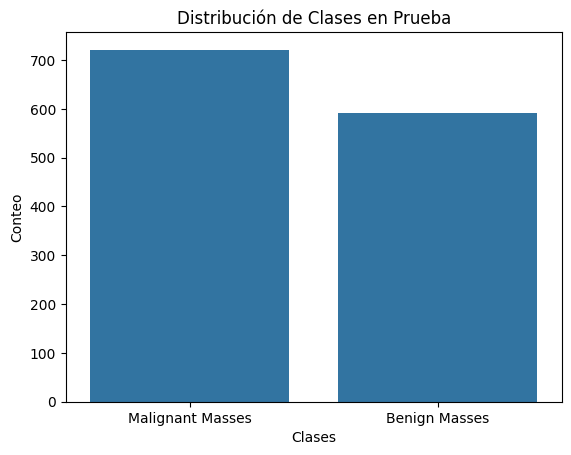

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Definir id2label y label2id correctamente
class_names = final_dataset['train'].features['label'].names  # ['Benign', 'Malignant']
id2label = {idx: name for idx, name in enumerate(class_names)}
label2id = {name: idx for idx, name in enumerate(class_names)}

print("id2label:", id2label)
print("label2id:", label2id)

# 2. Definir la función de transformación corregida
def transforms(batch):
    # Convertir imágenes a RGB si no lo están
    images = batch['image']
    images = [image.convert('RGB') if image.mode != 'RGB' else image for image in images]
    
    # Procesar las imágenes convertidas
    inputs = processor(images, return_tensors='pt')
    
    # Asignar etiquetas directamente desde 'label'
    inputs['labels'] = batch['label']
    return inputs

# 3. Aplicar las transformaciones al conjunto de datos procesado
processed_dataset = final_dataset.with_transform(transforms)

# 4. Verificar las columnas antes de proceder
print("Columnas en 'final_dataset['test']':", final_dataset['test'].column_names)
print("Columnas en 'processed_dataset['test']':", processed_dataset['test'].column_names)

# 5. Mostrar un ejemplo de una muestra del conjunto de prueba
print(final_dataset['test'][0])

# 6. Obtener las predicciones del modelo
predictions = trainer.predict(processed_dataset['test']).predictions.argmax(axis=1)

# 7. Obtener las etiquetas verdaderas desde la columna 'label'
labels_true = final_dataset['test']['label']

# 8. Convertir a listas de enteros
labels_true = [int(label) for label in labels_true]
predictions = [int(pred) for pred in predictions]

# 9. Verificar los tipos y longitudes
print(f"Tipo de labels_true: {type(labels_true)}")
print(f"Tipo de predictions: {type(predictions)}")
print(f"Longitud de labels_true: {len(labels_true)}")
print(f"Longitud de predictions: {len(predictions)}")
print(f"Primeras etiquetas verdaderas: {labels_true[:5]}")
print(f"Primeras predicciones: {predictions[:5]}")

# 10. Generar el reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(labels_true, predictions, target_names=list(id2label.values())))

# 11. Generar la matriz de confusión
cm = confusion_matrix(labels_true, predictions)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=list(id2label.values()), 
            yticklabels=list(id2label.values()), cmap='Blues')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.show()

# 12. Función para mostrar predicciones
def show_predictions(rows, cols):
    """
    Muestra una cuadrícula de imágenes con sus etiquetas reales y predicciones.

    Args:
        rows (int): Número de filas en la cuadrícula.
        cols (int): Número de columnas en la cuadrícula.
    """
    # Seleccionar índices aleatorios sin reemplazo
    total_samples = len(final_dataset['test'])
    sample_indices = np.random.choice(total_samples, size=rows * cols, replace=False)

    # Seleccionar muestras del conjunto de datos original
    samples = final_dataset['test'].select(sample_indices)

    # Seleccionar las mismas muestras del conjunto de datos procesado
    processed_samples = processed_dataset['test'].select(sample_indices)

    # Obtener las predicciones para las muestras seleccionadas
    predictions = trainer.predict(processed_samples).predictions.argmax(axis=1)

    # Crear la figura
    fig = plt.figure(figsize=(cols * 4, rows * 4))

    for i in range(rows * cols):
        img = samples[i]['image']
        prediction = predictions[i]
        label_real = samples[i]['label']
        label_pred = id2label[prediction]
        label = f"Real: {id2label[label_real]}\nPredicción: {label_pred}"

        fig.add_subplot(rows, cols, i + 1)
        if img.mode == 'L':
            plt.imshow(img, cmap='gray')  # Ajusta el cmap si tus imágenes son en escala de grises
        else:
            plt.imshow(img)
        plt.title(label)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 13. Llamar a la función para mostrar predicciones
show_predictions(rows=5, cols=5)

# 14. Verificar la integridad de las imágenes (Opcional)
from PIL import Image

for split in ['train', 'validation', 'test']:
    for i, sample in enumerate(final_dataset[split]):
        try:
            img = sample['image']
            img.verify()  # Solo si 'image' es un objeto PIL.Image
        except AttributeError:
            # Si 'image' no tiene el método 'verify', intenta abrirla
            try:
                img = sample['image']
                img = img.convert('RGB')
            except Exception as e:
                print(f"Imagen corrupta en {split}, índice {i}: {e}")
        except Exception as e:
            print(f"Imagen corrupta en {split}, índice {i}: {e}")

# 15. Validar la distribución de clases (Opcional)
import seaborn as sns
import matplotlib.pyplot as plt

def plot_class_distribution(dataset_split, split_name):
    labels = [id2label[label] for label in dataset_split['label']]
    sns.countplot(x=labels)
    plt.title(f'Distribución de Clases en {split_name}')
    plt.xlabel('Clases')
    plt.ylabel('Conteo')
    plt.show()

plot_class_distribution(final_dataset['train'], 'Entrenamiento')
plot_class_distribution(final_dataset['validation'], 'Validación')
plot_class_distribution(final_dataset['test'], 'Prueba')
